In [4]:
import os
import pandas as pd

# Set the directory path where the CSV files are located
dir_path = r"C:\Users\eterp\OneDrive\Documents\USD\AAI_590_Capstone\HUPA-UCM Diabetes Dataset\HUPA-UCM Diabetes Dataset\Preprocessed"

# Create an empty list to store the dataframes
dfs = []

# Iterate over the files from HUPA0001P to HUPA0028P
for i in range(1, 29):
    # Construct the file name with zero-padding
    file_name = f"HUPA{str(i).zfill(4)}P.csv"
    
    # Join the directory path and file name
    file_path = os.path.join(dir_path, file_name)
    
    # Check if the file exists to avoid errors
    if os.path.exists(file_path):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path, sep=";")
        
        # Add a column for subject ID
        df['subject_id'] = i
        
        # Append the DataFrame to the list
        dfs.append(df)
        
        # Assign the DataFrame to an individual variable
        globals()[f"df{i}"] = df
    else:
        print(f"File {file_name} does not exist in the directory.")

# Optional: print a confirmation
print("All files have been imported successfully.")


File HUPA0008P.csv does not exist in the directory.
File HUPA0012P.csv does not exist in the directory.
File HUPA0013P.csv does not exist in the directory.
All files have been imported successfully.


In [5]:
# Combine all DataFrames in the list `dfs` into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame to confirm
print(combined_df.head())
print("\nNumber of rows and columns in the combined DataFrame:", combined_df.shape)

                  time  glucose  calories  heart_rate  steps  basal_rate  \
0  2018-06-13T18:40:00    332.0    6.3595   82.322835   34.0    0.091667   
1  2018-06-13T18:45:00    326.0    7.7280   83.740157    0.0    0.091667   
2  2018-06-13T18:50:00    330.0    4.7495   80.525180    0.0    0.091667   
3  2018-06-13T18:55:00    324.0    6.3595   89.129032   20.0    0.091667   
4  2018-06-13T19:00:00    306.0    5.1520   92.495652    0.0    0.075000   

   bolus_volume_delivered  carb_input  subject_id  
0                     0.0         0.0           1  
1                     0.0         0.0           1  
2                     0.0         0.0           1  
3                     0.0         0.0           1  
4                     0.0         0.0           1  

Number of rows and columns in the combined DataFrame: (309392, 9)


In [7]:
# Keep only the 'time', 'glucose', and 'subject_id' columns
combined_df = combined_df[['time', 'glucose', 'subject_id']]

# Display the first few rows to confirm the change
print(combined_df.head())

                  time  glucose  subject_id
0  2018-06-13T18:40:00    332.0           1
1  2018-06-13T18:45:00    326.0           1
2  2018-06-13T18:50:00    330.0           1
3  2018-06-13T18:55:00    324.0           1
4  2018-06-13T19:00:00    306.0           1


In [8]:
combined_df['time'] = pd.to_datetime(combined_df['time'])

In [9]:
print(combined_df.isnull().sum())

time          0
glucose       0
subject_id    0
dtype: int64


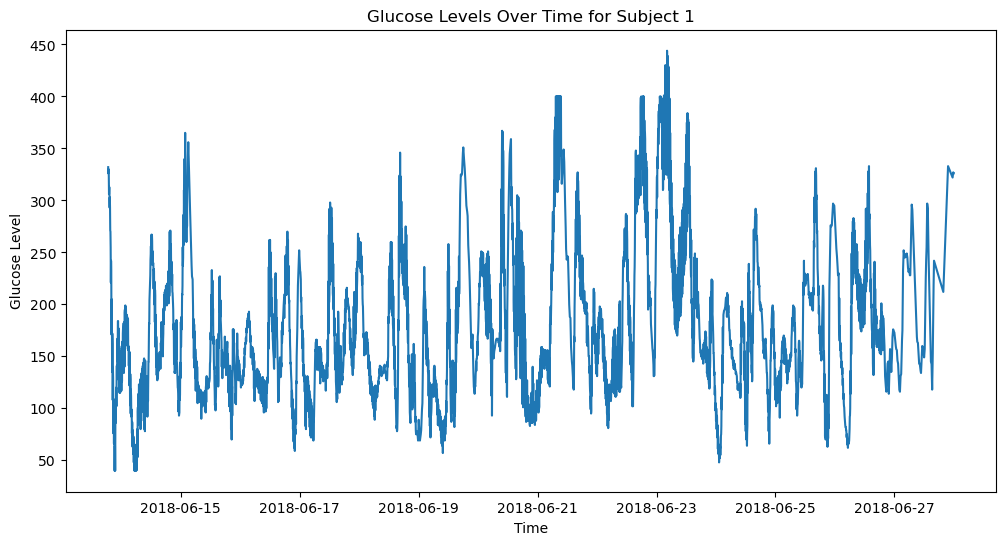

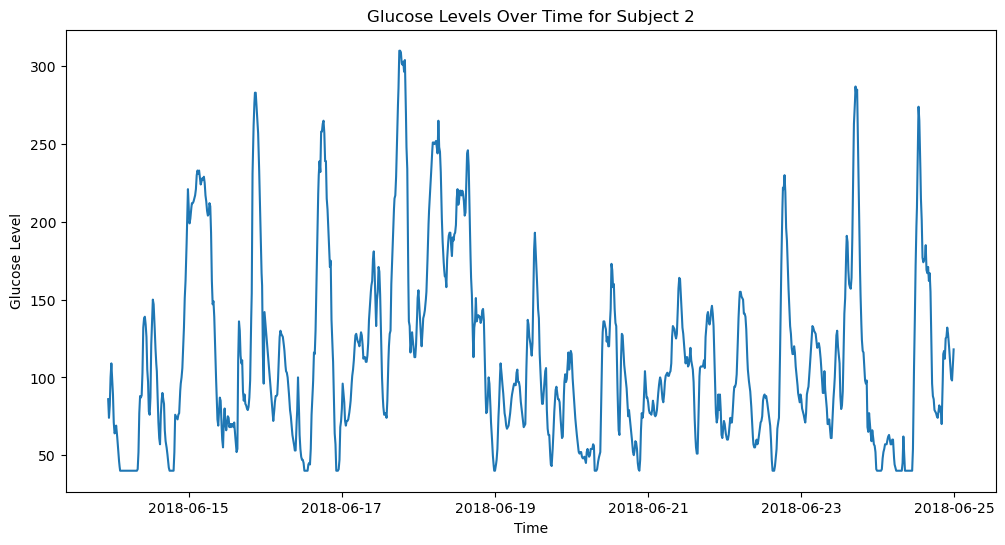

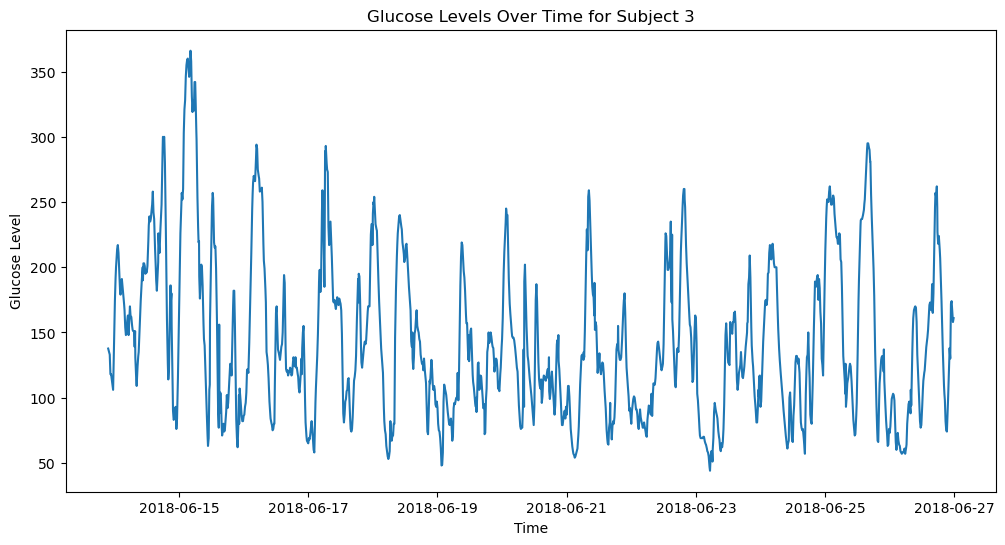

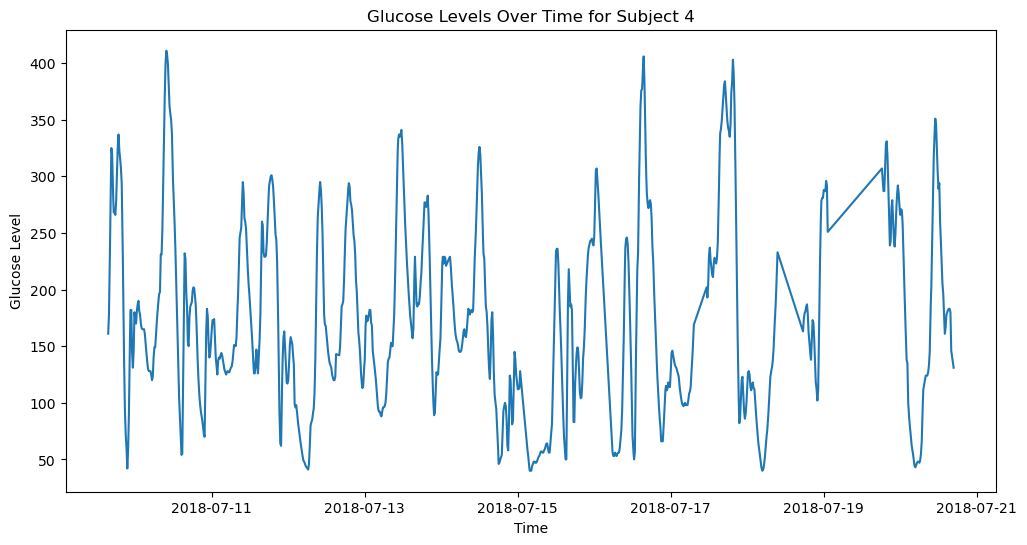

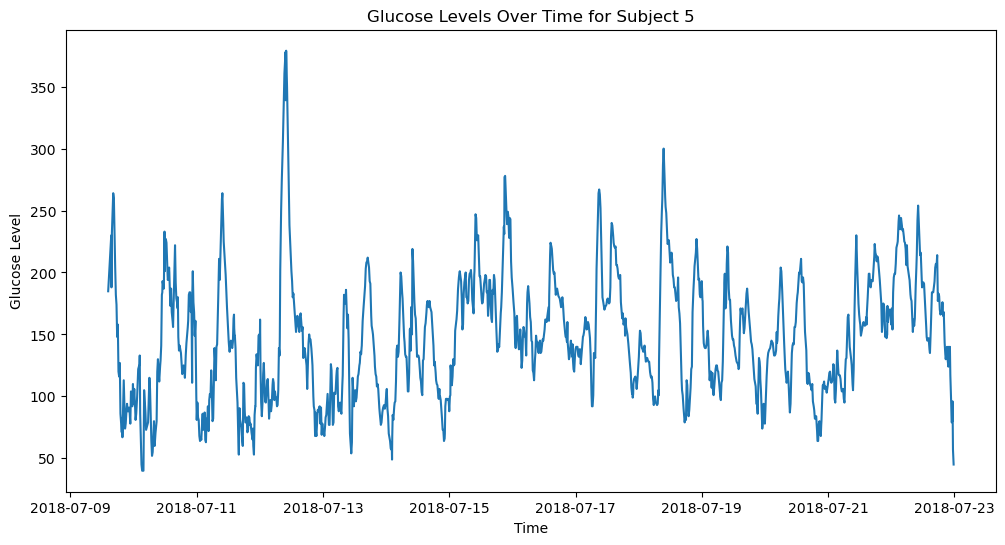

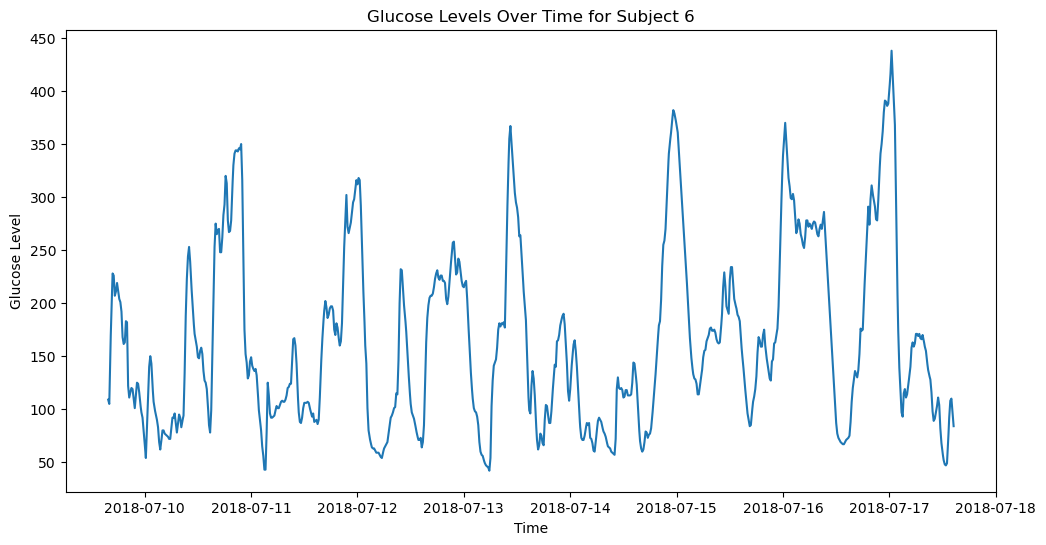

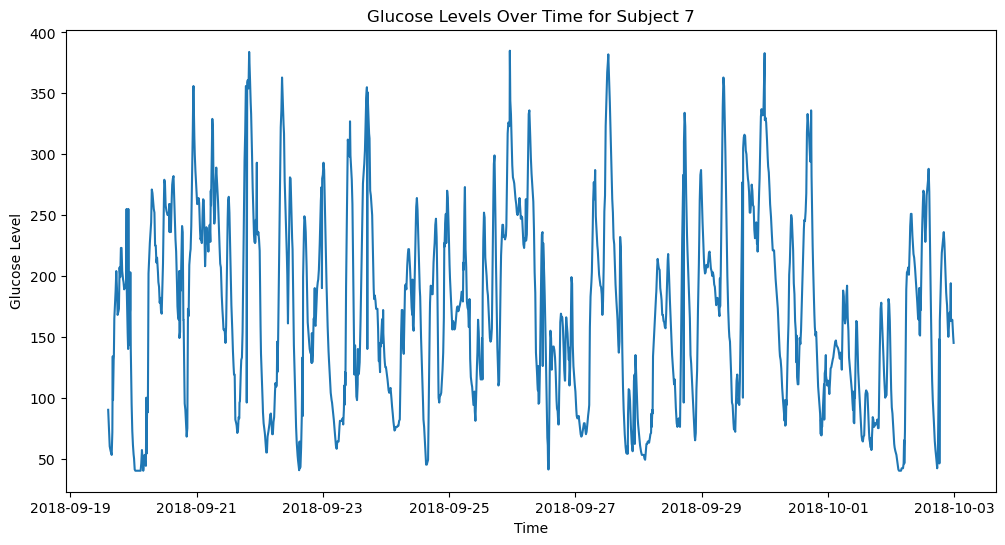

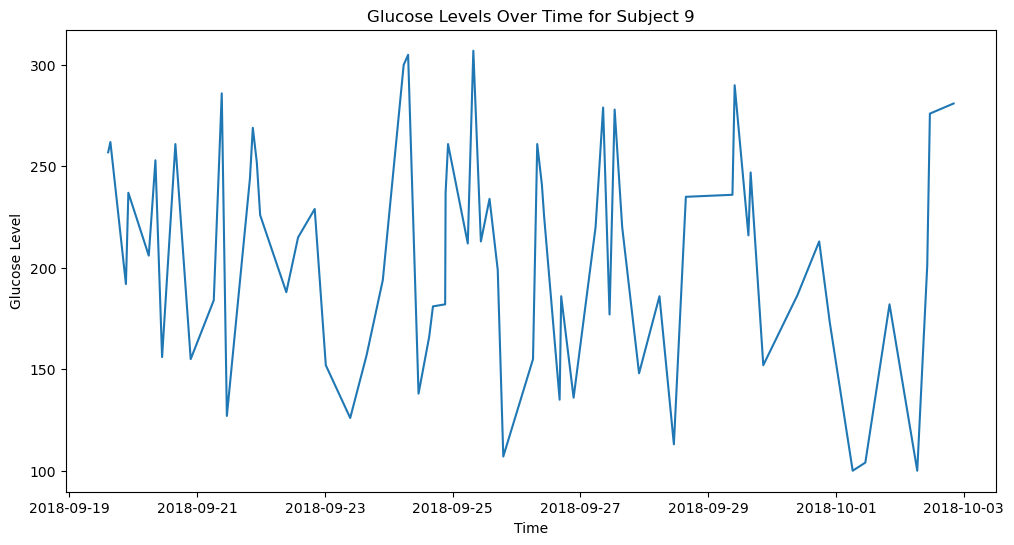

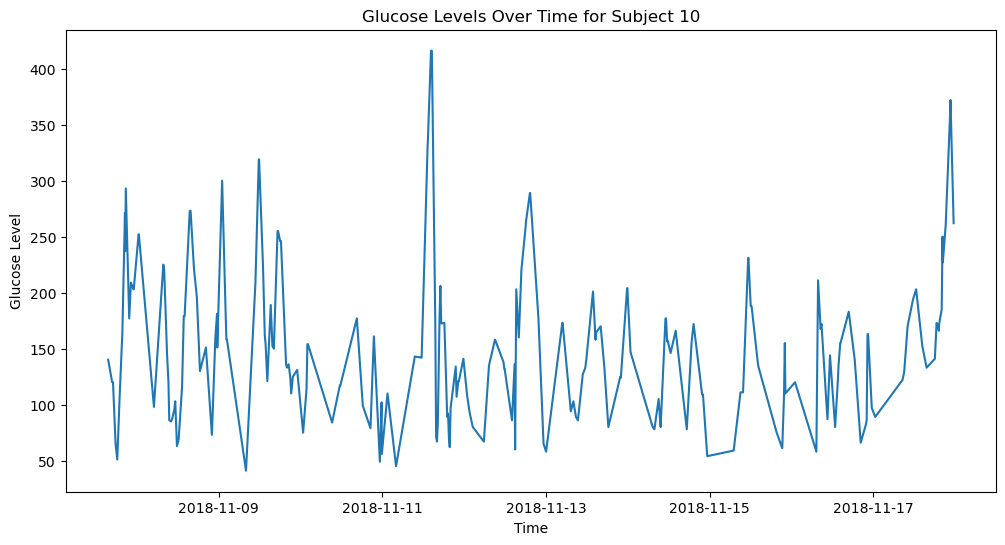

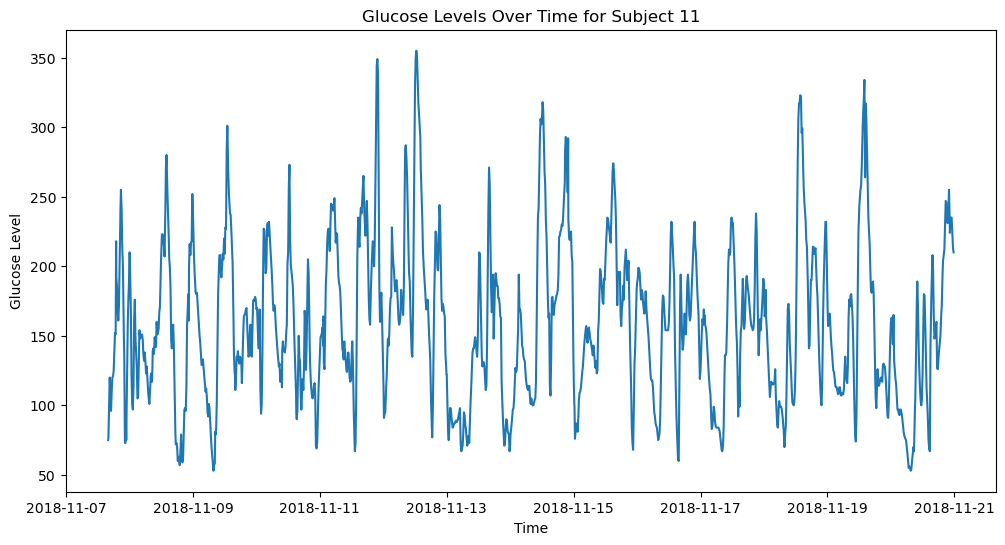

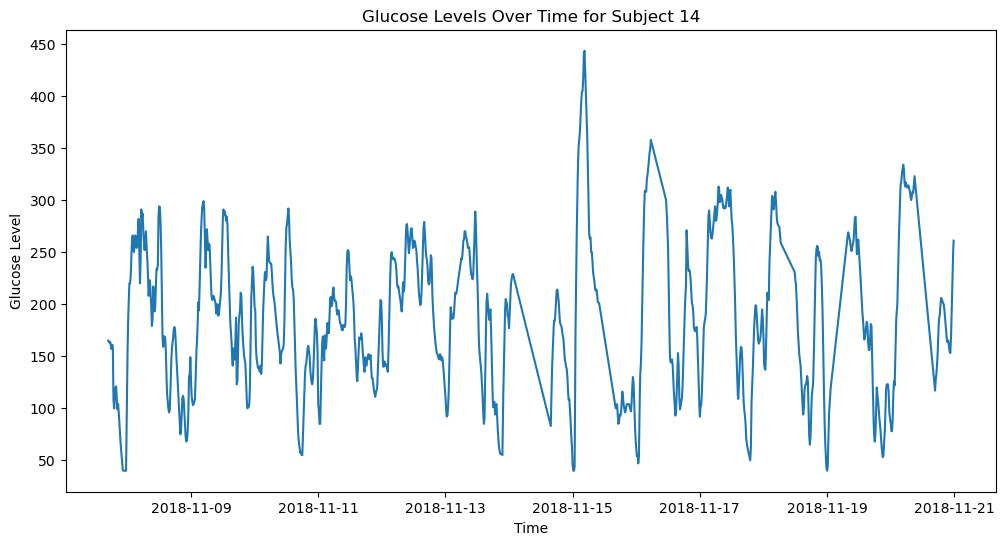

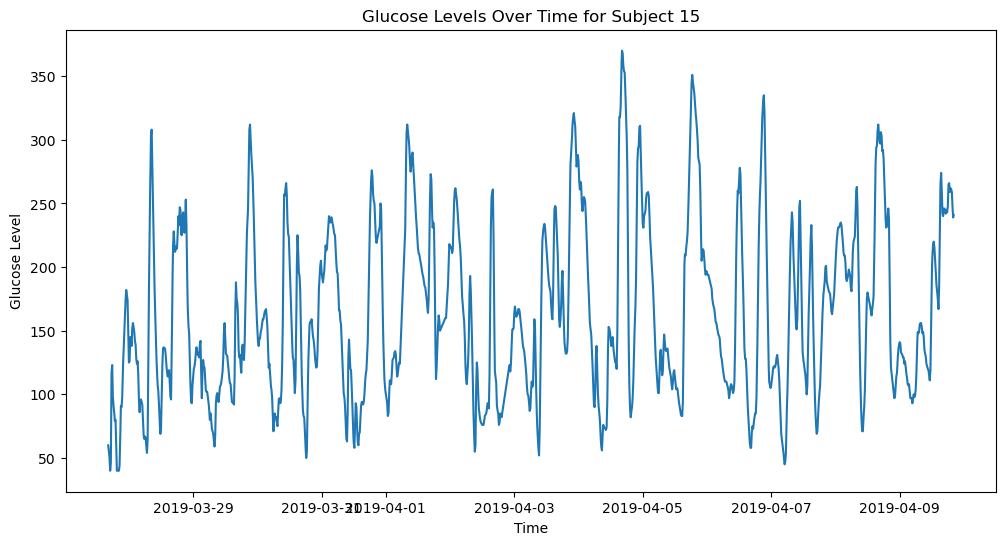

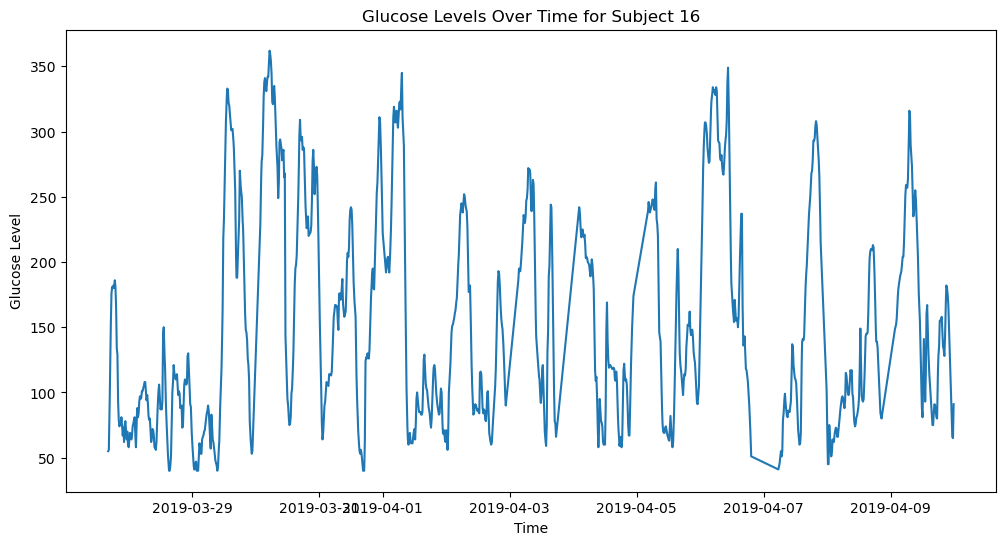

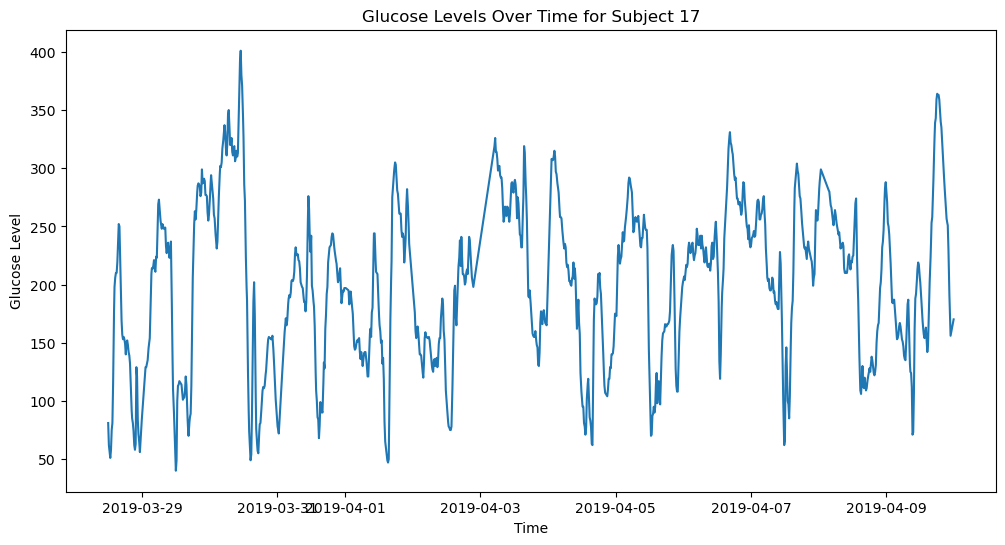

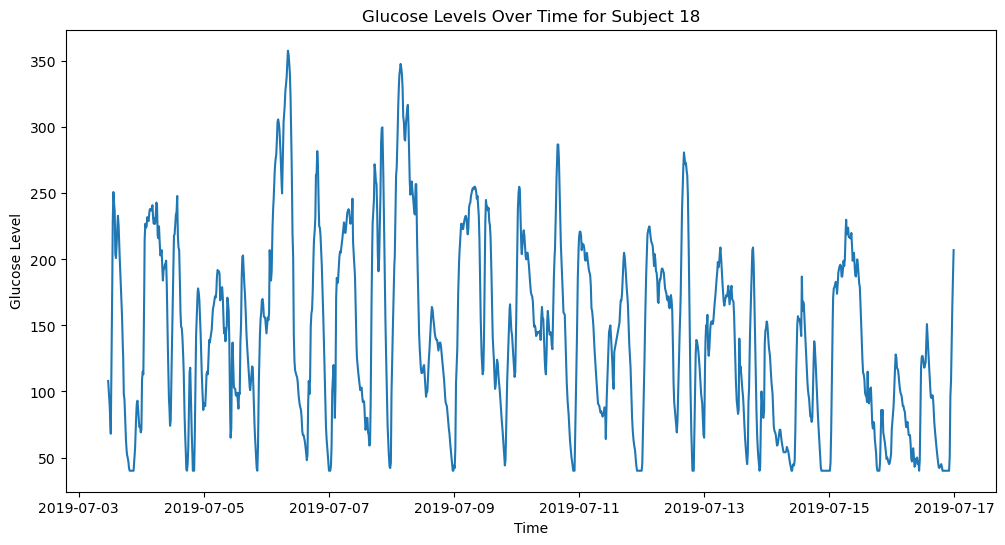

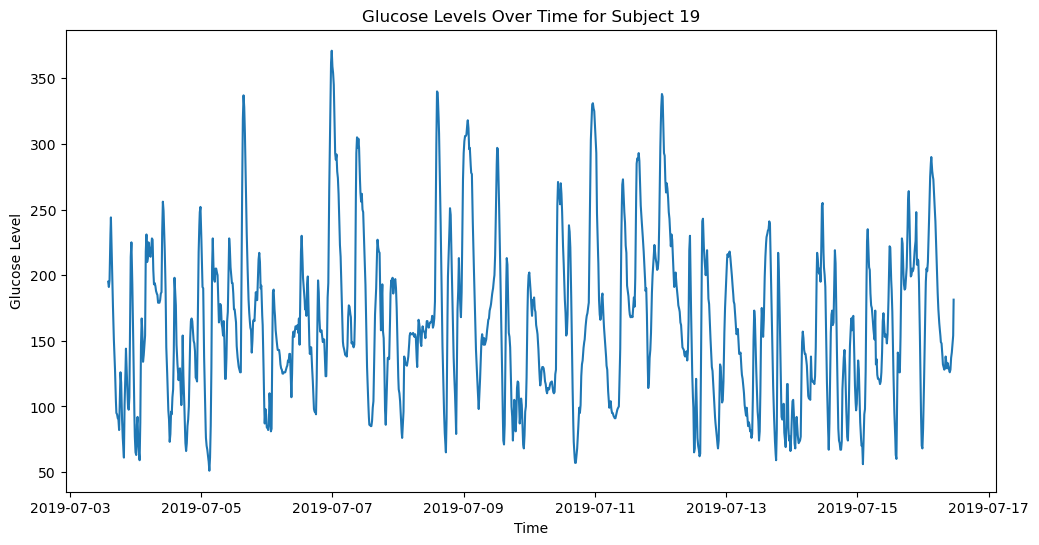

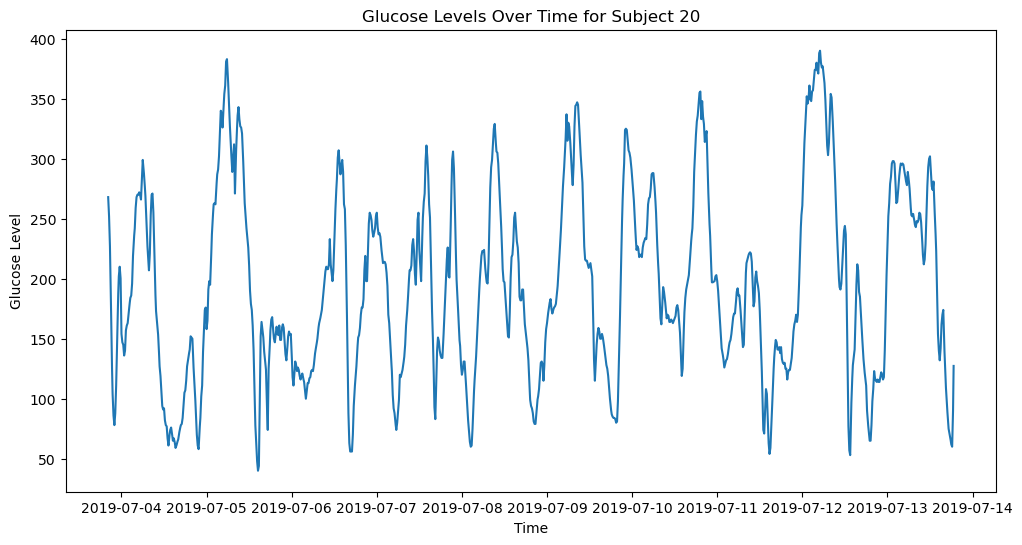

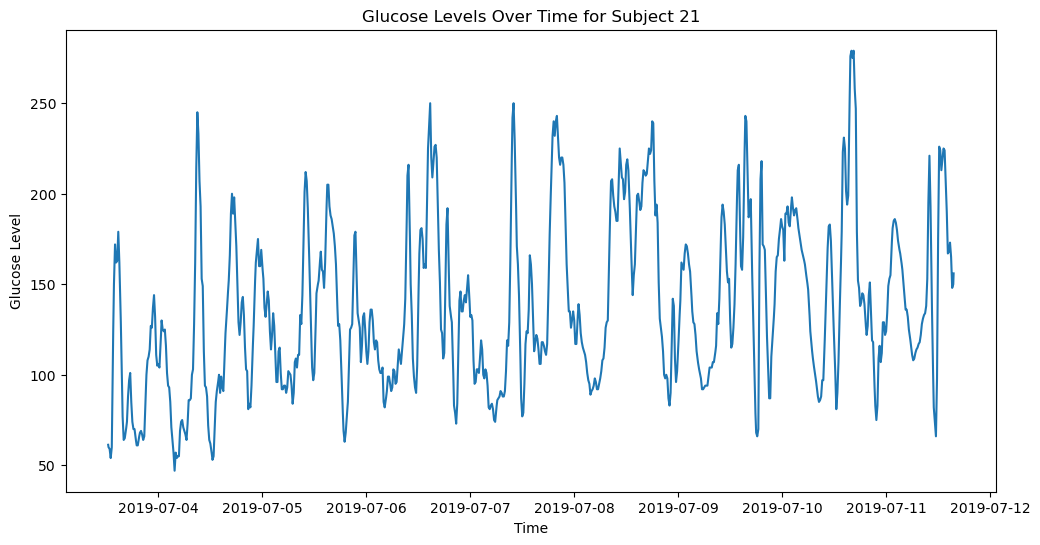

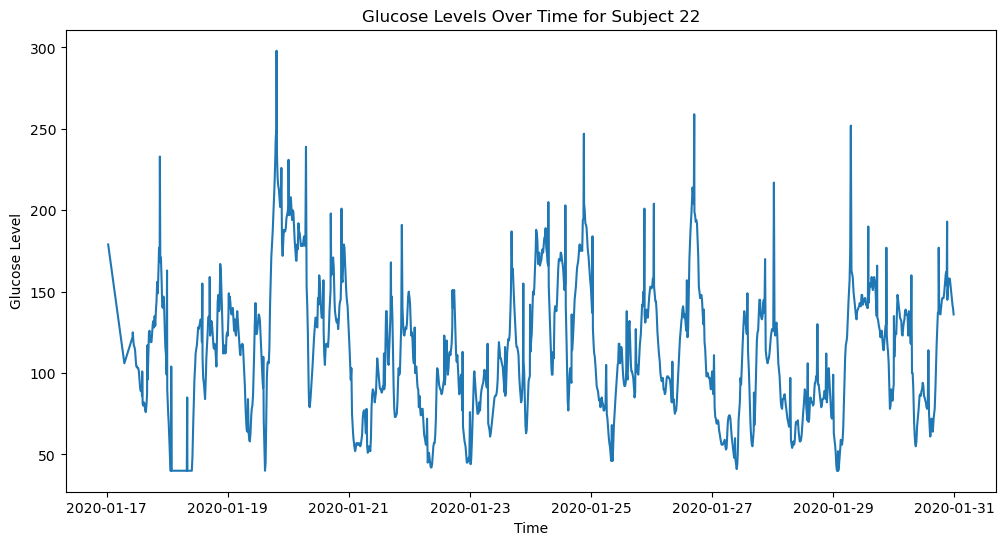

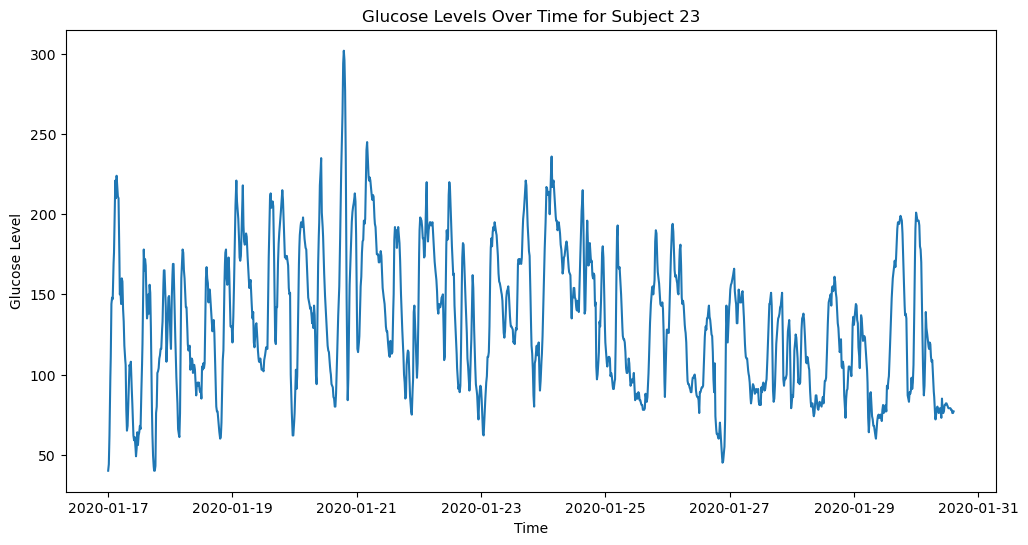

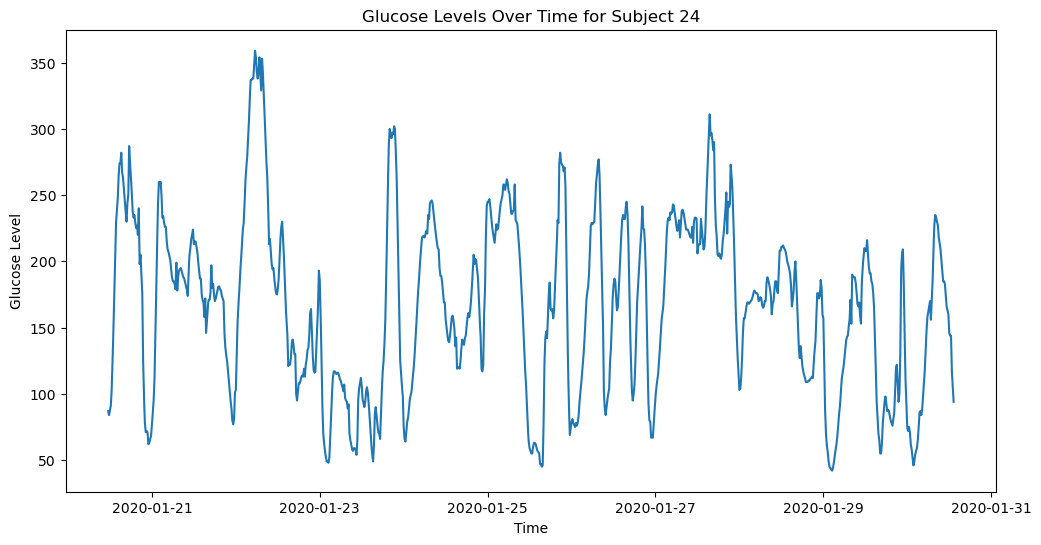

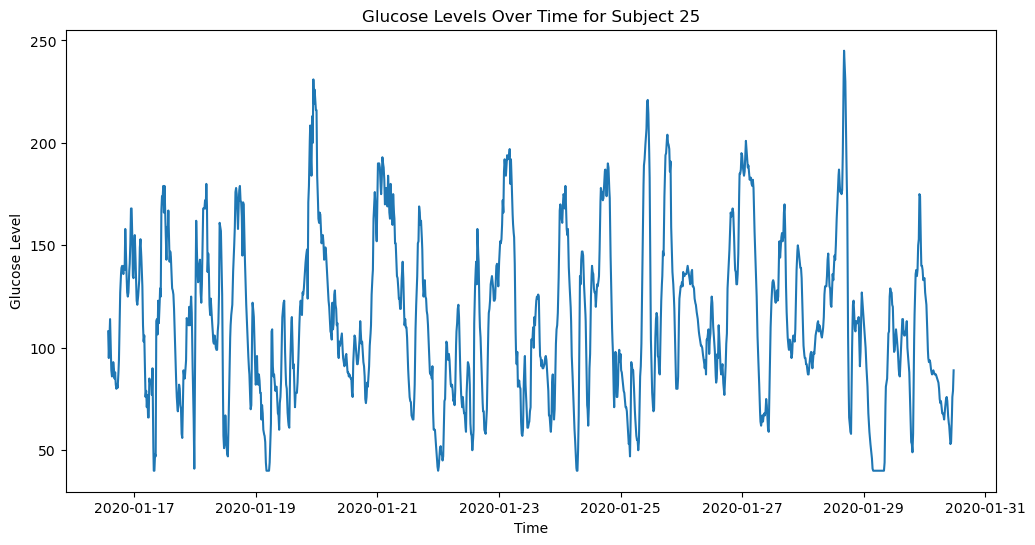

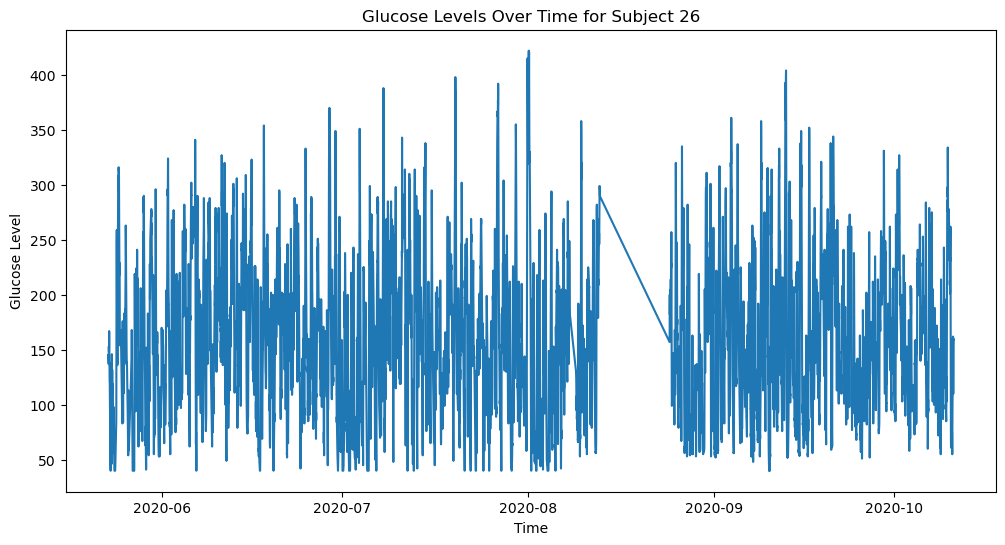

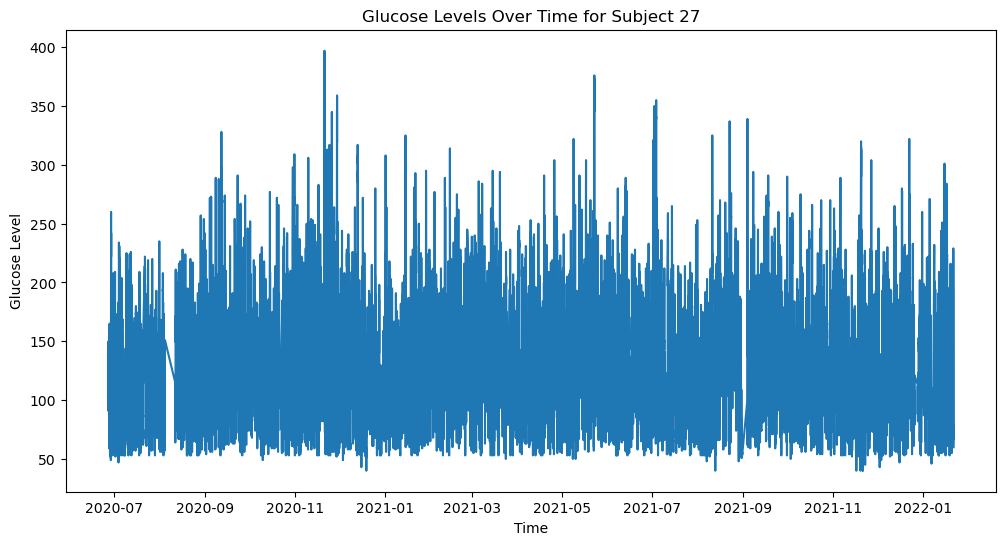

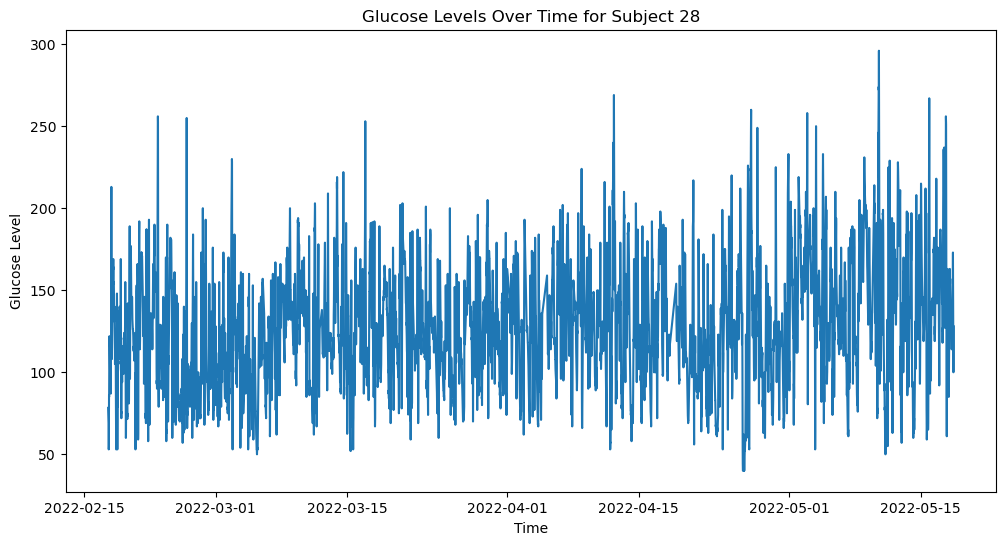

In [10]:
import matplotlib.pyplot as plt

subject_ids = combined_df['subject_id'].unique()
for subject_id in subject_ids:
    subject_data = combined_df[combined_df['subject_id'] == subject_id]
    plt.figure(figsize=(12, 6))
    plt.plot(subject_data['time'], subject_data['glucose'])
    plt.title(f"Glucose Levels Over Time for Subject {subject_id}")
    plt.xlabel("Time")
    plt.ylabel("Glucose Level")
    plt.show()


# Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Min-Max scaler to scale glucose values to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform glucose values
combined_df['glucose_scaled'] = scaler.fit_transform(combined_df[['glucose']])

# Display the original and scaled glucose values to verify
print(combined_df[['glucose', 'glucose_scaled']].head())


   glucose  glucose_scaled
0    332.0        0.722772
1    326.0        0.707921
2    330.0        0.717822
3    324.0        0.702970
4    306.0        0.658416


In [13]:
import numpy as np

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        # Get the sequence of length `seq_length`
        sequences.append(data[i:i + seq_length])
        # The target is the next value after the sequence
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Use a sequence length of 10 for glucose prediction
seq_length = 10
X, y = create_sequences(combined_df['glucose_scaled'].values, seq_length)


In [14]:
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [15]:
X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
X_val = X_val.reshape((X_val.shape[0], seq_length, 1))


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0014 - val_loss: 5.2510e-05
Epoch 2/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 1.6362e-04 - val_loss: 7.1339e-05
Epoch 3/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 1.4191e-04 - val_loss: 3.1991e-05
Epoch 4/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 1.1424e-04 - val_loss: 2.9827e-05
Epoch 5/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 9.8705e-05 - val_loss: 3.1330e-05
Epoch 6/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 8.6952e-05 - val_loss: 2.5199e-05
Epoch 7/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 9.4783e-05 - val_loss: 2.5274e-05
Epoch 8/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 8.5713e-05 - val_loss: 2.6690e-05
Epoch 9/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 7.8661e-05 - val_loss: 2.3876e-05
Epoch 10/50
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 7.9573e-05 - val_loss: 2.4000e-05
Epoch 11/50
7735/7735 ━━━━━━━━━━━

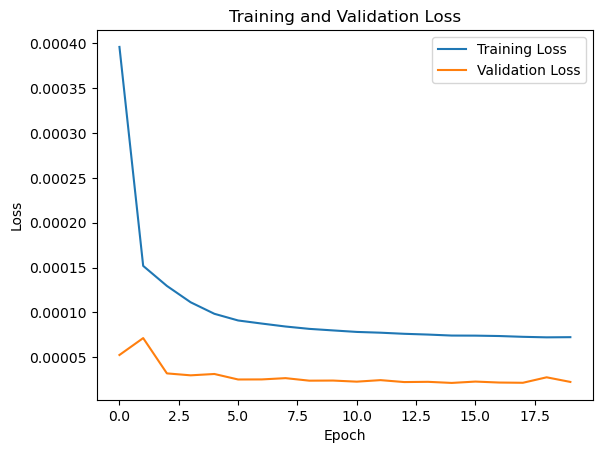

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile the model with Mean Squared Error loss and Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training and validation loss to monitor performance
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the validation set
y_pred = model.predict(X_val)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Absolute Error (MAE): 0.0022421583078079833
Root Mean Squared Error (RMSE): 0.0046225564644670775



Training model with 32 units and sequence length 5


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


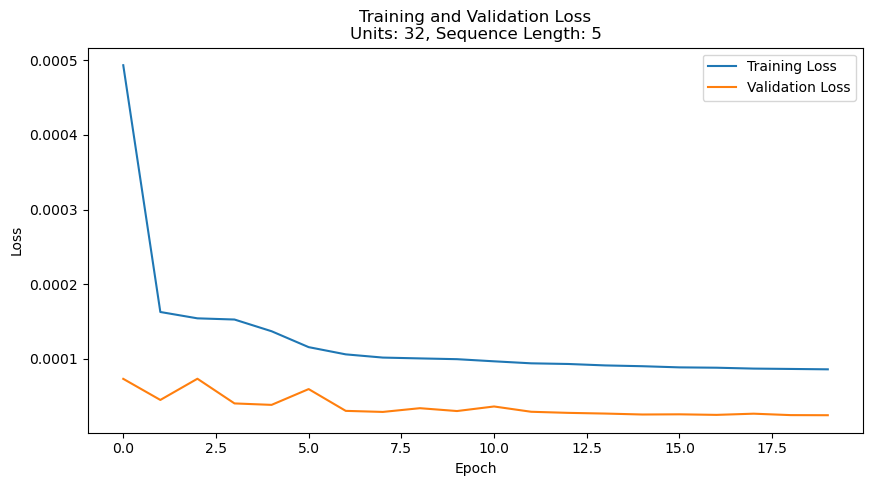

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Absolute Error (MAE): 0.0025
Root Mean Squared Error (RMSE): 0.0049

Training model with 32 units and sequence length 10


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


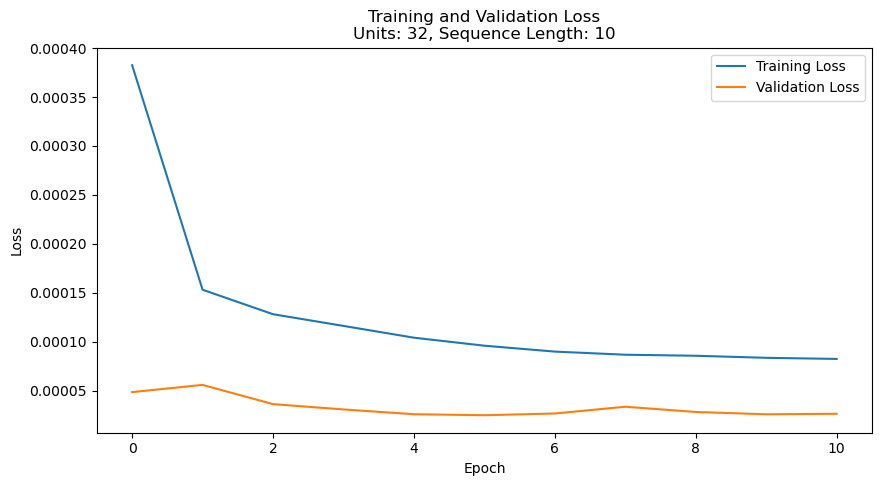

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Absolute Error (MAE): 0.0027
Root Mean Squared Error (RMSE): 0.0050

Training model with 32 units and sequence length 15


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


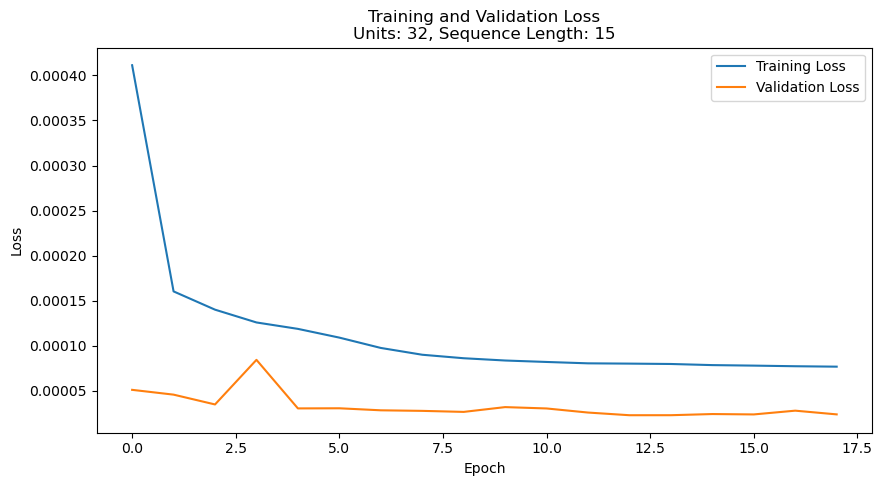

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Absolute Error (MAE): 0.0024
Root Mean Squared Error (RMSE): 0.0048

Training model with 50 units and sequence length 5


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


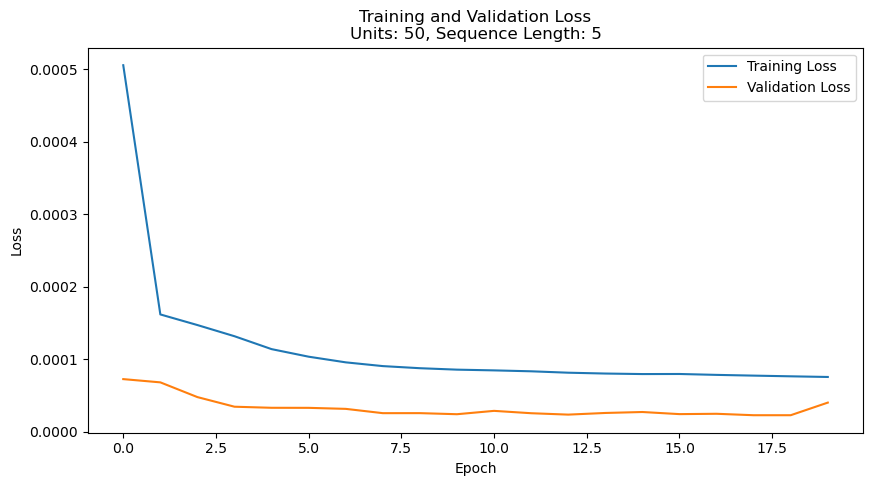

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mean Absolute Error (MAE): 0.0024
Root Mean Squared Error (RMSE): 0.0048

Training model with 50 units and sequence length 10


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


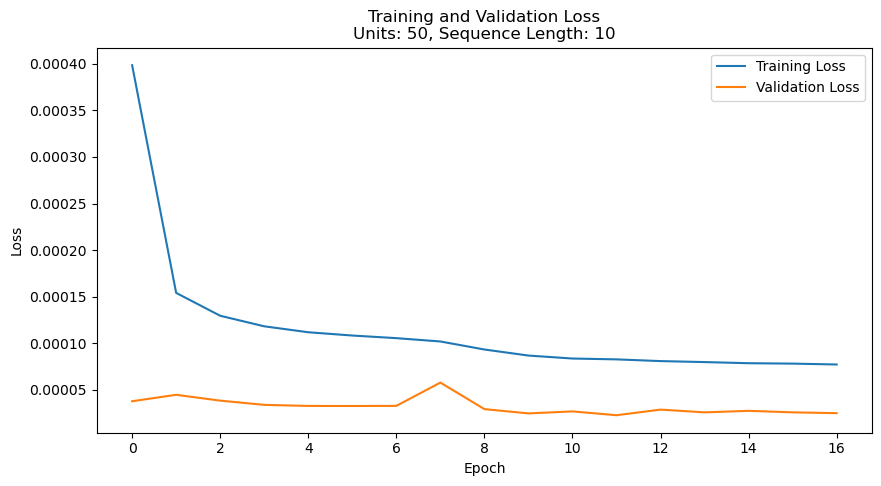

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Absolute Error (MAE): 0.0025
Root Mean Squared Error (RMSE): 0.0048

Training model with 50 units and sequence length 15


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


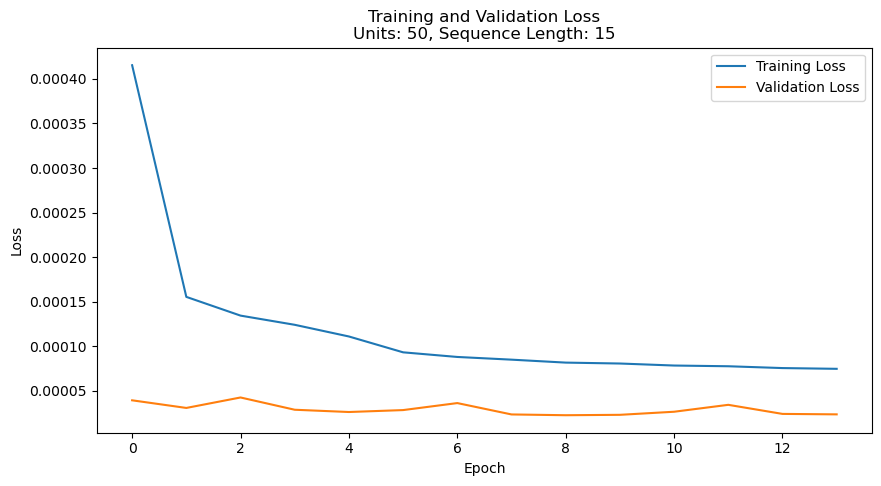

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Absolute Error (MAE): 0.0027
Root Mean Squared Error (RMSE): 0.0048

Training model with 64 units and sequence length 5


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


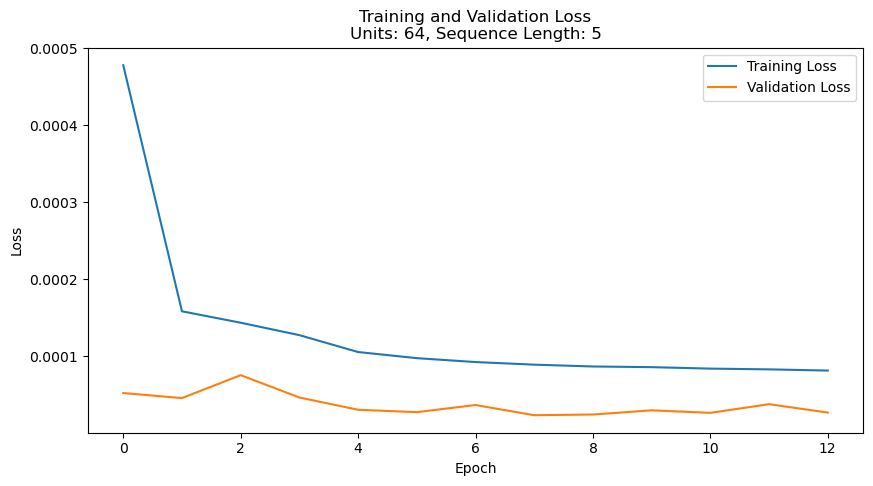

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Absolute Error (MAE): 0.0024
Root Mean Squared Error (RMSE): 0.0048

Training model with 64 units and sequence length 10


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


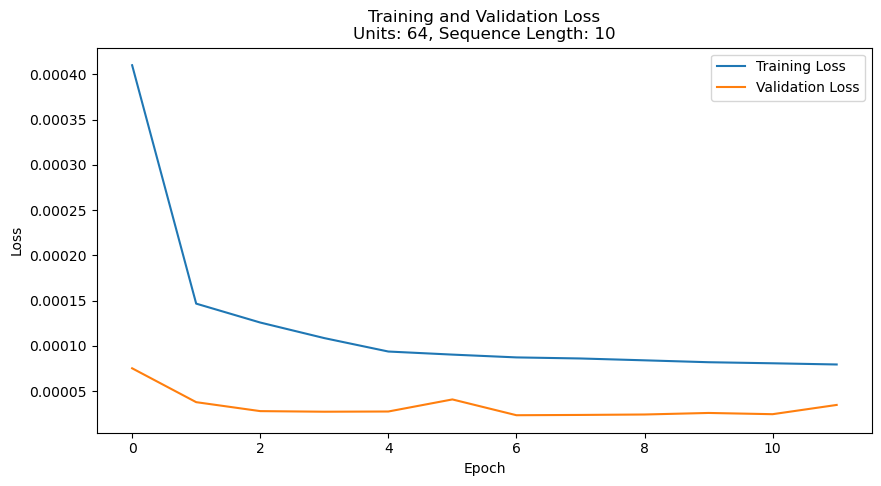

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Absolute Error (MAE): 0.0025
Root Mean Squared Error (RMSE): 0.0048

Training model with 64 units and sequence length 15


c:\Users\eterp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


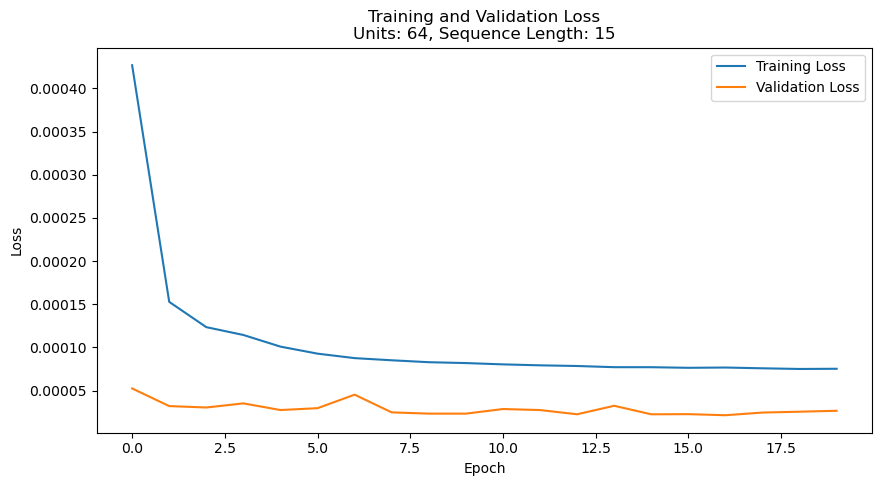

1934/1934 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Absolute Error (MAE): 0.0024
Root Mean Squared Error (RMSE): 0.0046


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
def load_data(directory_path):
    dfs = []
    for i in range(1, 29):
        file_name = f"HUPA{str(i).zfill(4)}P.csv"
        file_path = os.path.join(directory_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=";")
            df['subject_id'] = i
            dfs.append(df)
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
    else:
        raise ValueError("No files found in the specified directory.")
    combined_df = combined_df[['time', 'glucose', 'subject_id']]
    combined_df['time'] = pd.to_datetime(combined_df['time'])
    return combined_df

# Scale the glucose values
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data['glucose_scaled'] = scaler.fit_transform(data[['glucose']])
    return data, scaler

# Create sequences for time series prediction
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Define LSTM model
def create_lstm_model(seq_length, units):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Plot training and validation loss
def plot_loss(history, units, seq_length):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Training and Validation Loss\nUnits: {units}, Sequence Length: {seq_length}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate model and print metrics
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Main execution
dir_path = r"HUPA-UCM Diabetes Dataset\HUPA-UCM Diabetes Dataset\Preprocessed"
combined_df = load_data(dir_path)
combined_df, scaler = scale_data(combined_df)

# Experiment with different units and sequence lengths
for units in [32, 50, 64]:
    for seq_length in [5, 10, 15]:
        print(f"\nTraining model with {units} units and sequence length {seq_length}")
        
        # Generate sequences and split into training and validation sets
        X, y = create_sequences(combined_df['glucose_scaled'].values, seq_length)
        train_size = int(len(X) * 0.8)
        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:], y[train_size:]
        X_train = X_train.reshape((X_train.shape[0], seq_length, 1))
        X_val = X_val.reshape((X_val.shape[0], seq_length, 1))

        # Initialize and train the model
        model = create_lstm_model(seq_length, units)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
        
        # Plot training and validation loss
        plot_loss(history, units, seq_length)
        
        # Evaluate model
        evaluate_model(model, X_val, y_val)


In [ ]:
from tensorflow.keras.layers import Layer, Input, LSTM, Dense, Bidirectional, Permute, Multiply, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return output

# Define the model with an attention layer
def create_lstm_with_attention(seq_length, units):
    inputs = Input(shape=(seq_length, 1))
    lstm_out = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    attention_out = Attention()(lstm_out)
    attention_out = Flatten()(attention_out)
    outputs = Dense(1)(attention_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Ensure the sequence length matches the data preparation step
seq_length = X_train.shape[1]  # Set the sequence length based on the prepared data
units = 64       # Number of LSTM units
attention_model = create_lstm_with_attention(seq_length, units)

# Train the model (using earlier prepared X_train and y_train)
history = attention_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 84s 10ms/step - loss: 0.0018 - val_loss: 5.5663e-05
Epoch 2/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - loss: 1.4890e-04 - val_loss: 3.5950e-05
Epoch 3/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - loss: 1.1388e-04 - val_loss: 3.9031e-05
Epoch 4/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 76s 10ms/step - loss: 1.1541e-04 - val_loss: 4.4214e-05
Epoch 5/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - loss: 1.1749e-04 - val_loss: 3.7538e-05
Epoch 6/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 72s 9ms/step - loss: 1.1060e-04 - val_loss: 4.8403e-05
Epoch 7/20
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 68s 9ms/step - loss: 1.0927e-04 - val_loss: 3.0948e-05
Epoch 8/20
7676/7735 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0282e-04